In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import os
from scipy import stats
from sklearn.feature_selection import VarianceThreshold,f_classif
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

In [2]:
fileroot='/Users/jac/Documents/CD48_Feb19/'
figureroot=fileroot+'Figures/'

In [3]:
cd4=pd.read_pickle(fileroot+'Data/CD4_sequences.pkl')
cd8=pd.read_pickle(fileroot+'Data/CD8_sequences.pkl')

In [4]:
def MI_calculation(counts):
    MI=[]
    for col in counts.columns:
        for row in counts.index:
            joint=counts[col].loc[row]/np.sum(np.sum(counts))
            marginal_cell=counts[col].sum()/np.sum(np.sum(counts))
            marginal_feature=counts.loc[row].sum()/np.sum(np.sum(counts))
            if joint*marginal_cell*marginal_feature>0:
                MI.append(joint*np.log2((joint)/(marginal_cell*marginal_feature)))
    return np.sum(MI)

In [5]:
def count_matrix(four,eight):
    feature4,counts4=np.unique(four,return_counts=1)
    feature8,counts8=np.unique(eight,return_counts=1)
    features_all=np.unique(np.hstack((feature4,feature8)))
    counts=pd.DataFrame(np.zeros((len(features_all),2)),columns=['Four','Eight'],index=features_all)
    for x in features_all:
        if x in feature4:
            counts['Four'].loc[x]=counts4[np.where(x==feature4)[0][0]]
        if x in feature8:
            counts['Eight'].loc[x]=counts8[np.where(x==feature8)[0][0]]
    return counts

In [6]:
def finite_sampling_correction(four,eight):
    data=np.zeros((int(1e5),2))
    it=0
    for sample_size in np.arange(.5,1,.05):
        for iterations in range(10):
            data[it,0]=MI_calculation(count_matrix(four.sample(frac=.8),eight.sample(frac=.8)))
            data[it,1]=1/sample_size
            it+=1
    data=pd.DataFrame(data[:it,:],columns=['MI','SampleSize'])
    return stats.linregress(data.SampleSize,data.MI)[1]      

In [7]:
def get_cdr3_charge(cdr3):
    return cdr3.count('K')+cdr3.count('R')-cdr3.count('D')-cdr3.count('E')

In [8]:
cd4['Lengtha']=np.array(list(map(len,cd4.CDR3a)))
cd8['Lengtha']=np.array(list(map(len,cd8.CDR3a)))
cd4['Lengthb']=np.array(list(map(len,cd4.CDR3b)))
cd8['Lengthb']=np.array(list(map(len,cd8.CDR3b)))
cd4['Chargea']=np.array(list(map(get_cdr3_charge,cd4.CDR3a)))
cd8['Chargea']=np.array(list(map(get_cdr3_charge,cd8.CDR3a)))
cd4['Chargeb']=np.array(list(map(get_cdr3_charge,cd4.CDR3b)))
cd8['Chargeb']=np.array(list(map(get_cdr3_charge,cd8.CDR3b)))

In [9]:
data=pd.DataFrame(np.zeros((int(1e5),3)),columns=['Feature','MI','Chain'])
it=0
for feature in ['Va','Ja','Lengtha','Chargea','Vb','Jb','Lengthb','Chargeb']:
    for i in range(5):
        data['Feature'].iloc[it]=feature[:-1]
        data['Chain'].iloc[it]=feature[-1]
        data['MI'].iloc[it]=finite_sampling_correction(cd4[feature],cd8[feature])
        it+=1
data=data.iloc[:it]

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [10]:
a_plus_b=np.array(data[data.Chain=='a'].MI.astype(float))+np.array(data[data.Chain=='b'].MI.astype(float))

In [11]:
data_additive=pd.DataFrame(np.vstack((np.array(data[data.Chain=='a'].Feature),a_plus_b,['a+b']*a_plus_b.shape[0])).T,columns=data.columns)

In [12]:
data=data.append(data_additive)

In [13]:
data_paired=pd.DataFrame(np.zeros((int(1e5),3)),columns=['Feature','MI','Chain'])
it=0
for feature1,feature2 in zip(['Va','Ja','Chargea','Lengtha'],['Vb','Jb','Chargeb','Lengthb']):
    for i in range(5):
        data_paired['Feature'].iloc[it]=feature1[:-1]
        data_paired['Chain'].iloc[it]='ab'
        data_paired['MI'].iloc[it]=finite_sampling_correction(cd4[feature1].astype(str)+'_'+cd4[feature2].astype(str),cd8[feature1].astype(str)+'_'+cd8[feature2].astype(str))
        it+=1
data_paired=data_paired.iloc[:it]

In [14]:
df=data.append(data_paired)

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


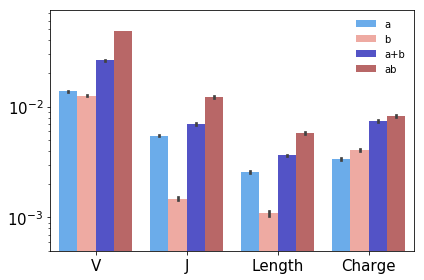

In [15]:
sns.barplot(df.Feature,df.MI,hue=df.Chain,palette=['Dodgerblue','Salmon','Mediumblue','Firebrick'],ci=99,alpha=.75)
plt.yscale('log')
plt.ylim([.0005,.075])
plt.legend(frameon=False)
plt.xlabel('')
plt.ylabel('')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.savefig(figureroot+'Figure4_A'+'.png',format='png', dpi=1200)
plt.show()
plt.close()

In [16]:
def vector(df):
    beta_j_order=['1-1','1-2','1-3','1-4','1-5','1-6','2-1','2-2','2-2P','2-3','2-4','2-5','2-6','2-7'];
    beta_v_order=['1','2','3-1','4-1','5-1','6-1','7-1','4-2','6-2','3-2','4-3','6-3','7-2','8-1','5-2','6-4','7-3','8-2','5-3','9','10-1','11-1','12-1','10-2','11-2','12-2','6-5','7-4','5-4','6-6','7-5','5-5','6-7','7-6','5-6','6-8','7-7','5-7','6-9','7-8','5-8','7-9','13','10-3','11-3','12-3','12-4','12-5','14','15','16','17','18','19','20-1','21-1','22-1','23-1','24-1','25-1','26','27','28','29-1','30'];
    alpha_v_order=['1-1','1-2','2','3','4','5','6','7','8-1','9-1','10','11','12-1','8-2','8-3','13-1','12-2','8-4','8-5','13-2','14DV4','9-2','15','12-3','8-6','16','17','18','19','20','21','22','23DV6','24','25','26-1','8-7','27','28','29DV5','30','31','32','33','26-2','34','35','36DV7','37','38-1','38-2DV8','39','40','41'];
    alpha_j_order=list(map(str,range(1,62)))
    aa='GALSTNKVYRIQDFPEMWHC' 
    alpha_df=np.zeros((df.shape[0],137))
    beta_df=np.zeros((df.shape[0],101))
    for i in range(df.shape[0]):
        row=df.iloc[i]
        va=np.zeros((1,len(alpha_v_order)))[0]
        va[np.where(row.Va==np.array(alpha_v_order))[0][0]]=1
        ja=np.zeros((1,len(alpha_j_order)))[0]
        ja[np.where(row.Ja==np.array(alpha_j_order))[0][0]]=1
        vb=np.zeros((1,len(beta_v_order)))[0]
        vb[np.where(row.Vb==np.array(beta_v_order))[0][0]]=1
        jb=np.zeros((1,len(beta_j_order)))[0]
        jb[np.where(row.Jb==np.array(beta_j_order))[0][0]]=1
        alpha_cdr3=np.zeros((1,20))[0]
        beta_cdr3=np.zeros((1,20))[0]
        for j,x in enumerate(aa):
            alpha_cdr3[j]=np.asscalar(np.char.count(row.CDR3a,x))
            beta_cdr3[j]=np.asscalar(np.char.count(row.CDR3b,x))
        alpha_cdr3,beta_cdr3=alpha_cdr3/np.sum(alpha_cdr3),beta_cdr3/np.sum(beta_cdr3)
        lengtha=len(row.CDR3a)
        lengthb=len(row.CDR3b)
        chargea=row.CDR3a.count('K')+row.CDR3a.count('R')-row.CDR3a.count('D')-row.CDR3a.count('E')
        chargeb=row.CDR3b.count('K')+row.CDR3b.count('R')-row.CDR3b.count('D')-row.CDR3b.count('E')
        alpha_df[i,:]=np.hstack((va,ja,lengtha,chargea,alpha_cdr3))
        beta_df[i,:]=np.hstack((vb,jb,lengthb,chargeb,beta_cdr3))
    return pd.DataFrame(alpha_df),pd.DataFrame(beta_df)

In [17]:
df4a,df4b=vector(cd4)
df8a,df8b=vector(cd8)

In [18]:
idx4=np.intersect1d(np.where(~pd.DataFrame(df4a).duplicated())[0],np.where(~pd.DataFrame(df4b).duplicated())[0])
idx8=np.intersect1d(np.where(~pd.DataFrame(df8a).duplicated())[0],np.where(~pd.DataFrame(df8b).duplicated())[0])

In [19]:
df4a,df4b=df4a.loc[idx4],df4b.loc[idx4]
df8a,df8b=df8a.loc[idx8],df8b.loc[idx8]

In [20]:
dfa,dfb=np.vstack((df4a,df8a)),np.vstack((df4b,df8b))
labels=np.hstack(([1]*df4a.shape[0],[0]*df8a.shape[0]))

In [21]:
it=0
skf = StratifiedKFold(n_splits=5)
for i in range(10):
    N=np.unique(labels,return_counts=1)[1][0]
    idx=np.hstack((np.random.permutation(np.where(labels==1)[0])[:N],np.random.permutation(np.where(labels==0)[0])[:N]))
    df_alpha=dfa[idx]
    df_beta=dfb[idx]
    df_labels=labels[idx]
    for train_index, test_index in skf.split(df_alpha,df_labels):
        
        alpha_train=df_alpha[train_index]
        beta_train=df_beta[train_index]
        train_labels=df_labels[train_index]

        alpha_test=df_alpha[test_index]
        beta_test=df_beta[test_index]
        test_labels=df_labels[test_index]

        s=VarianceThreshold(threshold=0).fit(alpha_train)
        alpha_train=alpha_train[:,s.get_support()]
        alpha_test=alpha_test[:,s.get_support()]

        s=VarianceThreshold(threshold=0).fit(beta_train)
        beta_train=beta_train[:,s.get_support()]
        beta_test=beta_test[:,s.get_support()]

        scaler=StandardScaler().fit(alpha_train)
        alpha_train=scaler.transform(alpha_train)
        alpha_test=scaler.transform(alpha_test)

        scaler=StandardScaler().fit(beta_train)
        beta_train=scaler.transform(beta_train)
        beta_test=scaler.transform(beta_test)

        features=f_classif(alpha_train,train_labels)[0]
        alpha_train=alpha_train[:,features>1]
        alpha_test=alpha_test[:,features>1]

        features=f_classif(beta_train,train_labels)[0]
        beta_train=beta_train[:,features>1]
        beta_test=beta_test[:,features>1]

        pair_train=np.hstack((alpha_train,beta_train))
        pair_test=np.hstack((alpha_test,beta_test))

        clf_alpha=XGBClassifier(n_estimators=1000,eval_metric = ["auc","error"],learning_rate = 0.01,subsample = .8,colsample_bytree = .8, min_child_weight =5,max_depth=10)
        clf_alpha.fit(alpha_train,train_labels) 

        clf_beta=XGBClassifier(n_estimators=1000,eval_metric = ["auc","error"],learning_rate = 0.01,subsample = .8,colsample_bytree = .8, min_child_weight =5,max_depth=10)
        clf_beta.fit(beta_train,train_labels)

        clf_pair=XGBClassifier(n_estimators=1000,eval_metric = ["auc","error"],learning_rate = 0.01,subsample = .8,colsample_bytree = .8, min_child_weight =5,max_depth=10)
        clf_pair.fit(pair_train,train_labels) 

        alpha_auc=roc_auc_score(test_labels,clf_alpha.predict_proba(alpha_test)[:,1])    
        beta_auc=roc_auc_score(test_labels,clf_beta.predict_proba(beta_test)[:,1])  
        pair_auc=roc_auc_score(test_labels,clf_pair.predict_proba(pair_test)[:,1])

        alpha_score=accuracy_score(test_labels,clf_alpha.predict(alpha_test))    
        beta_score=accuracy_score(test_labels,clf_beta.predict(beta_test))  
        pair_score=accuracy_score(test_labels,clf_pair.predict(pair_test))

        alpha_plus_beta=(clf_alpha.predict_proba(alpha_test)[:,1]+clf_beta.predict_proba(beta_test)[:,1])/2
        additive_auc=roc_auc_score(test_labels,alpha_plus_beta)
        additive_score=accuracy_score(test_labels,[1 if x >=0.5 else 0 for x in alpha_plus_beta])

        afpr, atpr, athresholds = metrics.roc_curve(test_labels,clf_alpha.predict_proba(alpha_test)[:,1])
        bfpr, btpr, bthresholds = metrics.roc_curve(test_labels,clf_beta.predict_proba(beta_test)[:,1])
        pfpr, ptpr, pthresholds = metrics.roc_curve(test_labels,clf_pair.predict_proba(pair_test)[:,1])
        addfpr,addtpr,addthresholds= metrics.roc_curve(test_labels,alpha_plus_beta)

        a=np.vstack((afpr,atpr,['Alpha']*len(afpr))).T
        b=np.vstack((bfpr,btpr,['Beta']*len(bfpr))).T
        add=np.vstack((addfpr,addtpr,['Add']*len(addfpr))).T
        p=np.vstack((pfpr,ptpr,['Pair']*len(pfpr))).T
        df_roc=np.vstack((a,b,add,p))

        a=np.hstack((alpha_auc,alpha_score,['Alpha']))
        b=np.hstack((beta_auc,beta_score,['Beta']))
        p=np.hstack((pair_auc,pair_score,['Pair']))
        add=np.hstack((additive_auc,additive_score,['Add']))
        df_score=np.vstack((a,b,add,p))
        
        if it==0:
            df_all_roc=df_roc
            df_all_score=df_score
        else:
            df_all_roc=np.vstack((df_all_roc,df_roc))
            df_all_score=np.vstack((df_all_score,df_score))
        it+=1
df_all_score=pd.DataFrame(df_all_score,columns=['AUC','Accuracy','Type'])
df_all_roc=pd.DataFrame(df_all_roc,columns=['FPR','TPR','Type'])

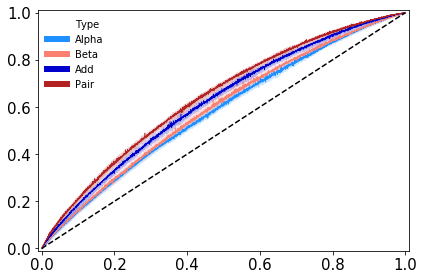

In [22]:
ax=sns.lineplot(df_all_roc.FPR.astype(float),df_all_roc.TPR.astype(float),hue=df_all_roc.Type,ci='sd',lw=.5,palette=['Dodgerblue','Salmon','Mediumblue','Firebrick'])
plt.plot([0,1],[0,1],'--k')
plt.xlim([-.01,1.01])
plt.ylim([-.01,1.01])
plt.xlabel('')
plt.ylabel('')
leg=ax.legend(frameon=False,fontsize=10)
for line in leg.get_lines():
    line.set_linewidth(6.0)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.savefig(figureroot+'Figure4_B'+'.png',format='png', dpi=1200)
plt.show()
plt.close()

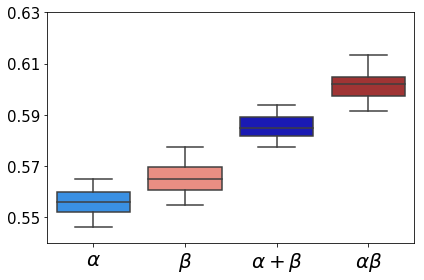

In [27]:
sns.boxplot(df_all_score.Type,df_all_score.Accuracy.astype(float),palette=['Dodgerblue','Salmon','Mediumblue','Firebrick'],boxprops=dict(alpha=1))
plt.ylim([.54,.63])
plt.xlabel('')
plt.ylabel('')
plt.legend('',frameon=False)
plt.xticks(np.arange(0,4),[r'$\alpha$',r'$\beta$',r'$\alpha + \beta$',r'$\alpha\beta$'],fontsize=20)
plt.yticks(np.arange(.55,.65,.02),fontsize=15)
plt.tight_layout()
plt.savefig(figureroot+'Figure4_C'+'.png',format='png', dpi=1200)
plt.show()
plt.close()

(0.56, 0.68)

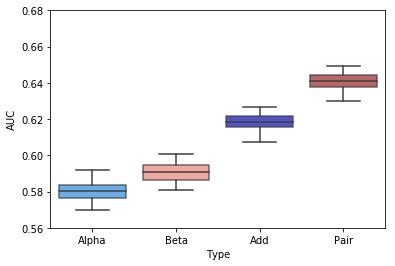

In [24]:
sns.boxplot(df_all_score.Type,df_all_score.AUC.astype(float),palette=['Dodgerblue','Salmon','Mediumblue','Firebrick'],boxprops=dict(alpha=.75))
plt.ylim([.56,.68])

In [25]:
for i,x in enumerate(['Alpha','Beta','Add','Pair']):
    for j,y in enumerate(['Alpha','Beta','Add','Pair']):
        if i<j:
            p=stats.mannwhitneyu(df_all_score[df_all_score.Type==x].Accuracy.astype(float),df_all_score[df_all_score.Type==y].Accuracy.astype(float))[1]
            print(x,y,p)

Alpha Beta 1.0423913007253935e-12
Alpha Add 3.525871262605358e-18
Alpha Pair 3.5250760345457436e-18
Beta Add 3.743587419399976e-18
Beta Pair 3.5242809763618545e-18
Add Pair 1.1640474701055079e-17
